# Plotting DVL and Slocum Glider Data with Pandas & Seaborn

---
## Import Libraries

In [1]:
import datetime
import earthpy as et
import earthpy.plot as ep
import importlib
import numpy as np
import os
import pandas as pd
import rasterio as rio
import scipy
import seaborn as sns 
import struct
import sys
import utm
import unittest
from PIL import Image
from matplotlib import pyplot as plt 
from os import listdir
from os.path import isfile, join

# add parent directory to the path for importing modules 
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import PathfinderDVL
import PathfinderEnsemble
import PathfinderTimeSeries
import PathfinderUtils
import SlocumFlightController
import SlocumScienceController
import dvl_plotter
sns.set()

def reload_modules():
    importlib.reload(PathfinderDVL)
    importlib.reload(PathfinderEnsemble)
    importlib.reload(PathfinderTimeSeries)
    importlib.reload(PathfinderUtils)
    importlib.reload(SlocumFlightController)
    importlib.reload(SlocumScienceController)
    importlib.reload(dvl_plotter)

---
## 0. Load or Parse Flight Computer Data

In [5]:
reload_modules()
directory = "/Users/zduguid/Dropbox (MIT)/MIT-WHOI/Kolumbo cruise 2019/zduguid/dbd-parsed/sentinel_2019-Nov/"
ts_flight_kolumbo_all = SlocumFlightController.SlocumFlightController.from_directory(directory, save=False, verbose=False)

>> Parsing folder of ASC Files
>> Finished Parsing!


---
## 1. Load or Parse DVL data 

In [2]:
reload_modules()
glider = "sentinel"
filepath = "/Users/zduguid/Dropbox (MIT)/MIT-WHOI/Kolumbo cruise 2019/zduguid/pd0-raw/%s/" % (glider)
# parse all of dives from Kolumbo
filename2  = "sk211652.pd0" # DIVE 2
filename3  = "01820002.pd0" # DIVE 3  -- long dive, lots of bottom track, variation in xy plane
filename4  = "sk220034.pd0" # DIVE 4
filename5  = "01820008.pd0" # DIVE 5
filename7  = "01820013.pd0" # DIVE 7
filename9  = "sk222256.pd0" # DIVE 9
filename12 = "sk230350.pd0" # DIVE 12
filename14 = "sk261222.pd0" # DIVE 14 -- long dive, intermittent bottom track, due north travel
ts2  = PathfinderTimeSeries.PathfinderTimeSeries.from_pd0(filepath+filename2,  save=False)
ts3  = PathfinderTimeSeries.PathfinderTimeSeries.from_pd0(filepath+filename3,  save=False)
ts4  = PathfinderTimeSeries.PathfinderTimeSeries.from_pd0(filepath+filename4,  save=False)
ts5  = PathfinderTimeSeries.PathfinderTimeSeries.from_pd0(filepath+filename5,  save=False)
ts7  = PathfinderTimeSeries.PathfinderTimeSeries.from_pd0(filepath+filename7,  save=False)
ts9  = PathfinderTimeSeries.PathfinderTimeSeries.from_pd0(filepath+filename9,  save=False)
ts12 = PathfinderTimeSeries.PathfinderTimeSeries.from_pd0(filepath+filename12, save=False)
ts14 = PathfinderTimeSeries.PathfinderTimeSeries.from_pd0(filepath+filename14, save=False)
tsa  = ts14
tsb  = ts12
tsc  = ts2
tsd  = ts3
tse  = ts4
tsf  = ts5

________________________________________
- Parsing DVL File ---------------------
    input file: sk211652.pd0
    # ensembles:    200
    # ensembles:    400
    # ensembles:    600
    # ensembles:    800
    # ensembles:   1000
    # ensembles:   1200
    # ensembles:   1400
    # ensembles:   1600
    # ensembles:   1800
    # ensembles:   2000
    # ensembles:   2200
    # ensembles:   2400
    # ensembles:   2600
    # ensembles:   2800
    # ensembles:   3000
    # ensembles:   3200
    # ensembles:   3400
- Parsing Complete ---------------------
    # ensembles:   3442
    parsing time:  10.938546
- Sensor Configuration -----------------
    600kHz System
    Convex Beam Pattern
    Sensor Config #1
    Attached
    Down Facing
    30E Beam Angle
    4 Beam Janus
- Coordinate Transformation ------------
    Bin Mapping Used
    3-Beam Soln Used
    Tilts Used
    Earth Coords
________________________________________
- Parsing DVL File ---------------------
    input file: 01820

---
## 2. Determine Water Column Currents from DVL data 

In [360]:
reload_modules()

# select a dive to work with
ts = tsa

# tuning parameters for working with DVL data 
pitch_bias           =  8    # [deg]   mounting pitch bias for the sonar
start_filter         =  2    # [bin #] avoid using the first number of bins
end_filter           =  2    # [bin #] avoid using the last number of bins 
# voc_mag_filter       =  0.5  # [m/s]   filter out ocean current 
# voc_delta_mag_filter =  0.3  # [m/s]   filter out deltas between layers
voc_mag_filter       =  1.0  # [m/s]   filter out ocean current 
voc_delta_mag_filter =  0.5
# [m/s]   filter out deltas between layers
near_surface_filter  = 10    # [m]     ignore Vtw when near surface 

# constants
DEG_TO_RAD = np.pi/180

# determine DVL parameters 
bin_len      = ts.df.depth_bin_length[0]
bin0_dist    = ts.df.bin0_distance[0]
bin_len      = np.cos(pitch_bias*DEG_TO_RAD)*bin_len
bin0_dist    = np.cos(pitch_bias*DEG_TO_RAD)*bin0_dist
max_range    = 80
max_depth    = int(np.max(ts.df.depth)+80)
x_beam       = 0
y_beam       = 1

# intialize water column
water_column = PathfinderUtils.WaterColumn(
    bin_len=bin_len, 
    bin0_dist=bin0_dist,
    max_depth=max_depth,
    start_filter=start_filter,
    end_filter=end_filter,
    voc_mag_filter=voc_mag_filter,
    voc_delta_mag_filter=voc_delta_mag_filter,
)

# iterate over the DVL ensembles 
for t in range(len(ts.df)):

    # only use Vtw from pressure sensor when submerged 
    depth = ts.df.depth[t]
    pitch = ts.df.pitch[t]
    roll  = ts.df.roll[t]
    if depth > near_surface_filter:
        vtw_u = ts.df.rel_vel_pressure_u[t]
        vtw_v = ts.df.rel_vel_pressure_v[t]
    # otherwise use the DVL to estimate the Vtw at the surface
    else:
        vtw_u = ts.df.rel_vel_dvl_u[t]
        vtw_v = ts.df.rel_vel_dvl_v[t]
    
    # extract Voc reference from bottom track velocity when available
    if not np.isnan(ts.df.abs_vel_btm_u[t]):
        vog_u = ts.df.abs_vel_btm_u[t]
        vog_v = ts.df.abs_vel_btm_v[t]
        voc_u = vog_u - vtw_u
        voc_v = vog_v - vtw_v
        voc_ref = PathfinderUtils.OceanCurrent(voc_u, voc_v, 0)
    else:
        voc_ref = PathfinderUtils.OceanCurrent()
        
    # add shear nodes for each DVL depth bin that meet the filter criteria
    num_good_vel_bins = ts.df.num_good_vel_bins[t]
    if num_good_vel_bins > start_filter+end_filter:        
        
        # determine if glider ascending or descending
        delta_z = ts.df.delta_z[t]
        if delta_z > 0:
            direction = 'descending'
        else:
            direction = 'ascending'

        # build list of velocity shears to add as ShearNode to water column
        delta_voc_u = []
        delta_voc_v = []

        # add all valid DVL bins to the shear list 
        #   + filtering of DVL bins will occur in the `add_shear_node` call
        for bin_num in range(int(num_good_vel_bins)):

            # retrieve the shear list from the DVL data 
            x_var = ts.get_profile_var_name('velocity', bin_num, x_beam)
            y_var = ts.get_profile_var_name('velocity', bin_num, y_beam)
            dvl_x = ts.df[x_var][t]
            dvl_y = ts.df[y_var][t]

            # compute delta between dead-reckoned through-water velocity & DVL
            delta_voc_u.append(vtw_u - (-dvl_x))
            delta_voc_v.append(vtw_v - (-dvl_y))

        shear_list = [PathfinderUtils.OceanCurrent(
                        delta_voc_u[i], 
                        delta_voc_v[i], 
                        0) 
                      for i in range(len(delta_voc_u))]

        # add shear node to the water column with shear list information 
        if len(shear_list):
            water_column.add_shear_node(
                z_true=depth,
                t=t,
                shear_list=shear_list,
                voc_ref=voc_ref,
                direction=direction,
                pitch=pitch,
                roll=roll,
            )

    # add voc_ref measurement to the water column even if shear list is empty  
    elif not voc_ref.is_none():
        water_column.add_shear_node(
            z_true=depth,
            t=t,
            shear_list=[],
            voc_ref=voc_ref,
            direction=direction,
            pitch=pitch,
            roll=roll,
        )
        
voc_u_list,voc_v_list,voc_w_list,voc_z_list = water_column.compute_averages()
print("> Finished Estimating Water Column Currents!")
# print(water_column.averages_to_str())

> Finished Estimating Water Column Currents!


---
## 3. Use Water Column Currents to Improve Odometry

In [355]:
# initialize list for new odometry
rel_pos_x = [0]
rel_pos_y = [0]
rel_pos_z = [0]

# set flag for setting GPS updates
flag_gps_fix_at_surface = False 

# extract the relevant portion of the glider flight computer
start_t = datetime.datetime.fromtimestamp(ts.df.time[0])
end_t   = datetime.datetime.fromtimestamp(ts.df.time[-1])
dur     = end_t - start_t 
df_dbd  = ts_flight_kolumbo_all.df[str(start_t):str(end_t)].copy()

# extract start_t position "origin" from the glider flight data 
for t in range(len(df_dbd)):
    if not np.isnan(df_dbd.m_x_lmc[t]):
        dbd_origin_x = df_dbd.m_x_lmc[t]
        dbd_origin_y = df_dbd.m_y_lmc[t]
        break

# iterate through the dive file to update odometry
for t in range(1,len(ts.df)):
    time    = ts.df.time[t]
    prev_x  = rel_pos_x[-1]
    prev_y  = rel_pos_y[-1]
    delta_t = ts.df.delta_t[t]
    depth   = ts.df.depth[t]
    
    # only use Vtw from pressure sensor when submerged 
    depth = ts.df.depth[t]
    if depth > near_surface_filter:
        vtw_u = ts.df.rel_vel_pressure_u[t]
        vtw_v = ts.df.rel_vel_pressure_v[t]
        flag_gps_fix_at_surface = False
    # otherwise use the DVL to estimate the Vtw at the surface
    else:
        vtw_u = ts.df.rel_vel_dvl_u[t]
        vtw_v = ts.df.rel_vel_dvl_v[t]
    
    # retrieve over ground velocity from DVL in bottom track 
    vog_u = ts.df.abs_vel_btm_u[t]
    vog_v = ts.df.abs_vel_btm_v[t]
    
    # retrieve ocean current estimate from water column 
    voc_u = voc_u_list[int(depth)]
    voc_v = voc_v_list[int(depth)]

    # initialize delta values to zero
    delta_x, delta_y = 0,0
    
    # CASE 1: use bottom track overground velocity if available
    if (not np.isnan(vog_u)):
        delta_x = vog_u*delta_t
        delta_y = vog_v*delta_t
        
    # CASE 2: use through water velocity and ocean current estimate if available
    elif (not np.isnan(vtw_u)) and (not np.isnan(voc_u)):
            delta_x = (vtw_u + voc_u)*delta_t
            delta_y = (vtw_v + voc_v)*delta_t

    # CASE 3: use through water velocity if available
    elif (not np.isnan(vtw_u)):
            delta_x = vtw_u*delta_t
            delta_y = vtw_v*delta_t

    # CASE 4: use ocean current estimate if available
    elif (not np.isnan(voc_u)):
            delta_x = voc_u*delta_t
            delta_y = voc_v*delta_t

    # set current position to DVL odometry result 
    cur_x = delta_x + prev_x
    cur_y = delta_y + prev_y
    
    # override current position if GPS fix is given 
    if depth < near_surface_filter:
        cur_time = datetime.datetime.fromtimestamp(time)
        cur_dbd  = df_dbd[str(cur_time):].copy()
        if (len(cur_dbd.m_gps_x_lmc) != 0):
            if not np.isnan(cur_dbd.m_gps_x_lmc[0]):
                cur_x = cur_dbd.m_gps_x_lmc[0] - dbd_origin_x
                cur_y = cur_dbd.m_gps_y_lmc[0] - dbd_origin_y
                flag_gps_fix_at_surface = True
    
    # update the odometry list of positions
    rel_pos_x.append(cur_x)
    rel_pos_y.append(cur_y)
    rel_pos_z.append(depth)

# add new odomety to the data frame
ts.df['rel_pos_x'] = rel_pos_x
ts.df['rel_pos_y'] = rel_pos_y
ts.df['rel_pos_z'] = rel_pos_z

print("> Finished Calculating Odometry!")

> Finished Calculating Odometry!


---
## Plotting: Improved Odometry and Water Column Currents

### DVL Odometry

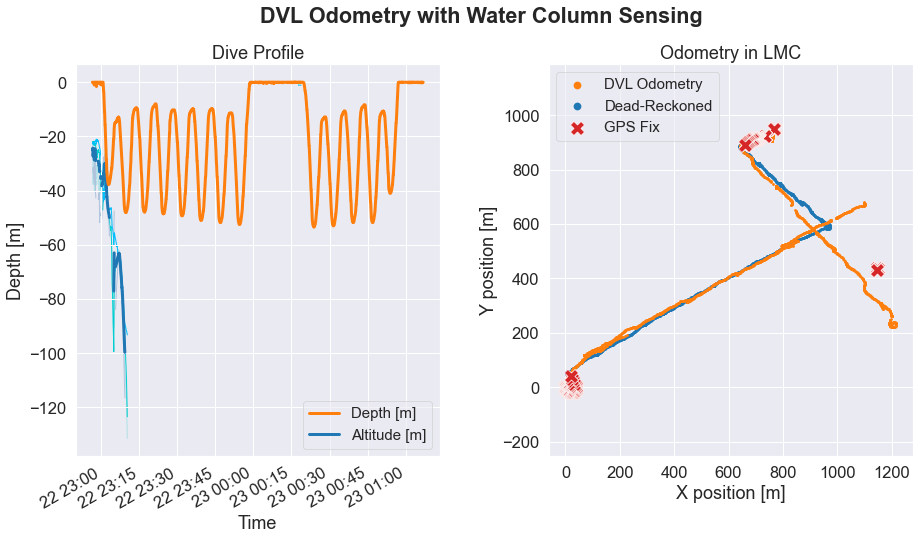

In [356]:
reload_modules()
dvl_plotter.plot_profile_and_odometry_and_dr(ts, ts_flight_kolumbo_all, save_name='tmp-profile.png')

### Water Column Currents

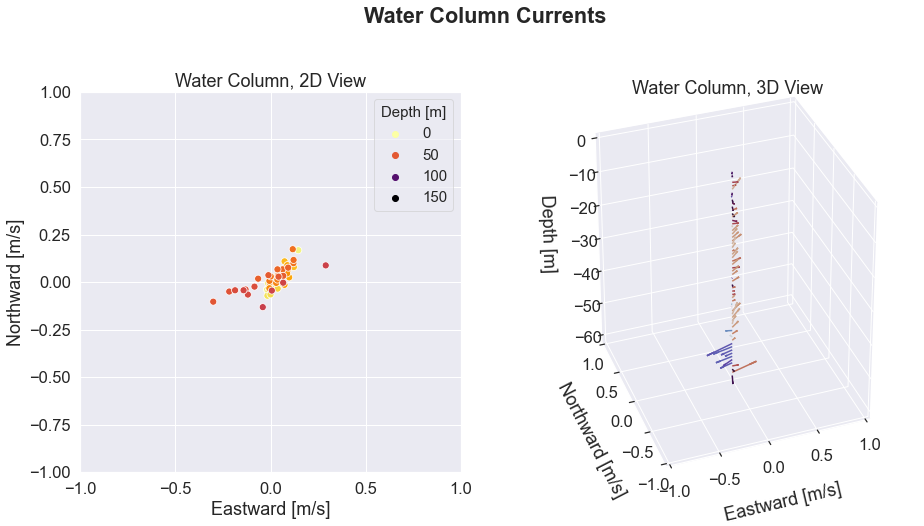

In [357]:
reload_modules()
dvl_plotter.plot_water_column_currents(voc_u_list, voc_v_list, voc_w_list, voc_z_list, save_name='tmp-water-column.png')

---
## Adaptive Velocity Control

Compare the performance of three glider control policies:
1. Constant velocity with buoyancy engine alone
2. Constant velocity with hybrid thruster (speed optimized w.r.t. hotel)
3. Adaptive velocity with hybrid thruster (speed optimized w.r.t. hotel and ocean currents)

In [358]:
# TODO list 
#   + take water column average for buoyancy case
    
# constants 
survey_hotel  = 6.37
E             = 3000
depth_filter  = 5
# eta           = 5.16
# eta           = 2.68
eta           = 8.95
# eta           = 1.57
constant_buoyancy_vtw    = 0.37
constant_buoyancy_p_prop = eta*(1/1000)*(3600/1)*(constant_buoyancy_vtw/1)

# possible velocities for adaptive controller to choose from
res    = 151
v_list = np.linspace(0,1.5,res)

# through water velocities for the two constant velocities conditions 
constant_hybrid_vtw    = get_opt_v(v_list, 0, 0, survey_hotel, E)
constant_hybrid_p_prop = get_prop_power(constant_hybrid_vtw)
constant_buoyancy_vtw  = 0.37

# initialize list of metrics that we are keeping track of 
mission_distance           = [0]
mission_currents_forward   = [0]
mission_currents_starboard = [0]
mission_currents_mag       = [0]

constant_buoyancy_time     = [0]
constant_buoyancy_energy   = [0] 

constant_hybrid_time       = [0]
constant_hybrid_energy     = [0] 

adaptive_hybrid_time       = [0]
adaptive_hybrid_energy     = [0]
adaptive_hybrid_velocity   = [0]
adaptive_hybrid_prop_p     = [0] 

# get averages of water column
cum_u,cum_v = 0,0
count = 0
for i in range(len(voc_u_list)):
    if not(np.isnan(voc_u_list[i])):
        cum_u   += voc_u_list[i]
        cum_v   += voc_v_list[i]
        count   += 1
avg_column_voc_u  = cum_u/count
avg_column_voc_v  = cum_v/count
avg_ocean_heading = np.arctan2(avg_column_voc_u,      avg_column_voc_v)
avg_ocean_mag     = np.linalg.norm([avg_column_voc_u, avg_column_voc_v])


# iterate over the dive to extract the optimal values
for t in range(1,len(ts.df)):
    # compute path of the glider 
    # + NOTE: all control models follow the same path
    # + NOTE: dont include time at surface (not relevant to transit)
    depth    = ts.df.depth[t]
    delta_x, delta_y = 0, 0
    if depth > depth_filter:
        delta_x  = ts.df.delta_x[t]
        delta_y  = ts.df.delta_y[t]
    distance = np.linalg.norm([delta_x, delta_y])
    
    # compute ocean current conditions at this location
    voc_u          = voc_u_list[int(depth)]
    voc_v          = voc_v_list[int(depth)]
    if np.isnan(voc_u):
        voc_u = 0
        voc_v = 0
    glider_heading = np.arctan2(delta_x, delta_y)
    ocean_heading  = np.arctan2(voc_u,   voc_v)
    ocean_mag      = np.linalg.norm([voc_u, voc_v])
    delta_heading  = ocean_heading - glider_heading 
    voc_para       = ocean_mag*np.cos(delta_heading)
    voc_perp       = ocean_mag*np.sin(delta_heading)
    
    # compute velocity components for water column average for buoyancy engine
    avg_delta_heading = avg_ocean_heading - glider_heading
    avg_voc_para      = avg_ocean_mag*np.cos(delta_heading)
    avg_voc_perp      = avg_ocean_mag*np.sin(delta_heading)
    
    # update mission lists 
    mission_distance.append(distance)
    mission_currents_forward.append(voc_para)
    mission_currents_starboard.append(voc_perp)
    mission_currents_mag.append(ocean_mag)
    
    # buoyancy control case 
    constant_buoyancy_vtw_para = (constant_buoyancy_vtw**2   - avg_voc_perp**2)**0.5
    constant_buoyancy_vog_para = (constant_buoyancy_vtw_para + avg_voc_para)
    delta_t                    = distance / constant_buoyancy_vog_para 
    constant_buoyancy_time.append(delta_t)
    constant_buoyancy_energy.append(delta_t * (constant_buoyancy_p_prop + survey_hotel))
    
    # constant hybrid control case 
    constant_hybrid_vtw_para = (constant_hybrid_vtw**2   - voc_perp**2)**0.5
    constant_hybrid_vog_para = (constant_hybrid_vtw_para + voc_para)
    delta_t                  = distance / constant_hybrid_vog_para 
    constant_hybrid_time.append(delta_t)
    constant_hybrid_energy.append(delta_t * (constant_hybrid_p_prop + constant_buoyancy_p_prop + survey_hotel))
    
    # adaptive hybrid control case 
    adaptive_hybrid_vtw      = get_opt_v(v_list, ocean_mag, delta_heading, survey_hotel, E)
    adaptive_hybrid_vtw_para = (adaptive_hybrid_vtw**2   - voc_perp**2)**0.5
    adaptive_hybrid_vog_para = (adaptive_hybrid_vtw_para + voc_para)
    delta_t                  = distance / adaptive_hybrid_vog_para 
    adaptive_hybrid_p_prop   = get_prop_power(adaptive_hybrid_vtw)
    adaptive_hybrid_time.append(delta_t)
    adaptive_hybrid_energy.append(delta_t * (adaptive_hybrid_p_prop + constant_buoyancy_p_prop + survey_hotel))
    adaptive_hybrid_velocity.append(adaptive_hybrid_vtw)
    

print('Mission Distance:  %.3f km'   % float(sum(mission_distance)/1000))
print()
print('Constant Buoyancy')
print('  Energy Consumed: %.3f Whrs' % float(sum(constant_buoyancy_energy)/3600))
print('  Mission Time:    %.3f min'  % float(sum(constant_buoyancy_time)/60))
print()
print('Constant Hybrid')
print('  Energy Consumed: %.3f Whrs' % float(sum(constant_hybrid_energy)/3600))
print('  Mission Time:    %.3f min'  % float(sum(constant_hybrid_time)/60))
print()
print('Adaptive Hybrid')
print('  Energy Consumed: %.3f Whrs' % float(sum(adaptive_hybrid_energy)/3600))
print('  Mission Time:    %.3f mins' % float(sum(adaptive_hybrid_time)/60))

Mission Distance:  2.146 km

Constant Buoyancy
  Energy Consumed: 28.719 Whrs
  Mission Time:    94.205 min

Constant Hybrid
  Energy Consumed: 15.158 Whrs
  Mission Time:    38.394 min

Adaptive Hybrid
  Energy Consumed: 15.158 Whrs
  Mission Time:    38.489 mins


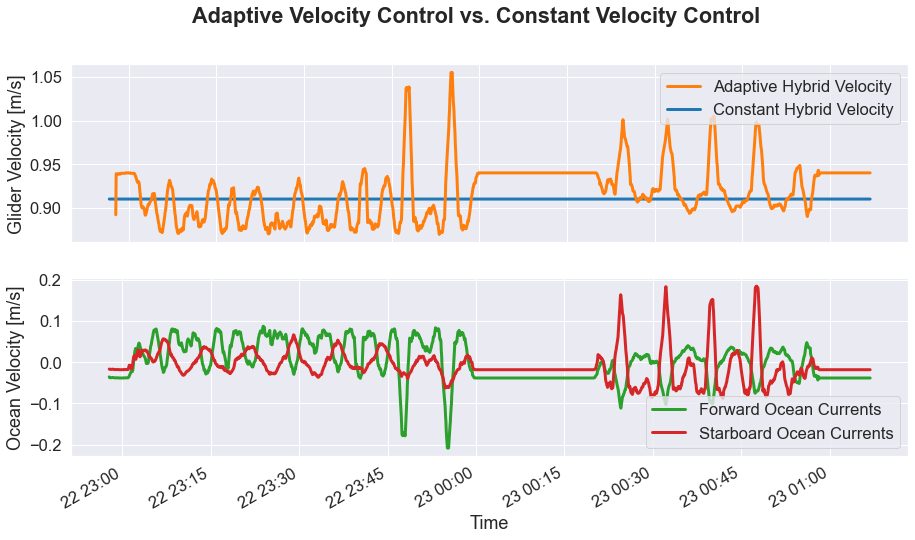

In [359]:
fig, ax = plt.subplots(2, figsize=(15,8))
roll_size = 20


roll_adaptive_hybrid_velocity   = list(pd.Series(adaptive_hybrid_velocity).rolling(roll_size).mean())
roll_mission_currents_forward   = list(pd.Series(mission_currents_forward).rolling(roll_size).mean())
roll_mission_currents_starboard = list(pd.Series(mission_currents_starboard).rolling(roll_size).mean())
ts.df['roll_adaptive_hybrid_velocity']   = roll_adaptive_hybrid_velocity
ts.df['roll_mission_currents_forward']   = roll_mission_currents_forward
ts.df['roll_mission_currents_starboard'] = roll_mission_currents_starboard
ts.df['roll_constant_hybrid_velocity']   = list(np.ones(len(roll_adaptive_hybrid_velocity))*constant_hybrid_vtw)
ts.df.roll_adaptive_hybrid_velocity.plot.line(lw=3,   ax=ax[0], label='Adaptive Hybrid Velocity', color='tab:orange', zorder=5)
ts.df.roll_constant_hybrid_velocity.plot.line(lw=3,   ax=ax[0], label='Constant Hybrid Velocity', color='tab:blue')

ts.df.roll_mission_currents_forward.plot.line(lw=3,   ax=ax[1], label='Forward Ocean Currents',   color='tab:green')
ts.df.roll_mission_currents_starboard.plot.line(lw=3, ax=ax[1], label='Starboard Ocean Currents', color='tab:red')
ax[0].set_xticklabels([])
ax[0].legend(loc='upper right')
ax[1].legend(loc='lower right')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Ocean Velocity [m/s]')
ax[0].set_ylabel('Glider Velocity [m/s]')
plt.suptitle('Adaptive Velocity Control vs. Constant Velocity Control', fontweight='bold')
plt.savefig("/Users/zduguid/Desktop/fig/tmp-adaptive-velocity-control.png")


In [64]:
DEG_TO_RAD       = np.pi/180
HOURS_TO_SECONDS = 60*60

def get_prop_power(v):
    '''Determines propulsive power needed to achieve through-water speed v, new model.
    '''
    vmin = 0.0
    vmax = 1.5
    v = max(min(v, vmax), vmin)
    c3 =  3.7856
    c2 =  1.9944
    c1 = -0.2221
    c0 =  1.0948
    return(c3*v**3 + c2*v**2 + c1*v + c0)


def get_opt_v(v_list, c, d, h, E, model_num=3):
    """Return optimal velocity from list of velocities given other operating conditions. 
    
    Args:
        v_list: list of possible velocity values to choose from 
        c: ocean current speed (magnitude)
        d: angle of ocean current relative to glider heading (heading of travel)
        h: hotel load of the vehicle 
        E: energy capacity of the vehicle (used for computing range)
        model_num: the glider efficiency model to use in the computation
    """
    r_list  = [get_range(g, c, d, h, E, model_num=model_num) for g in v_list]
    max_idx = np.nanargmax(r_list)
    max_r   = r_list[max_idx]
    opt_v   = v_list[max_idx]
    return(opt_v)


def get_range(v_g, v_c, delta, p_hotel, E, model_num=3):
    """Computes the range that can be achieved given the state variables.
    
    Args: 
        i: input current in [Amps]
        v_current: ocean current speed magnitude in [m/s]
        delta: angle between heading and v_current [rad]
        hotel: all non-propulsive power [Amps]
        E: total energy capacity [Amp-Hours]
        model_num: the glider efficiency model to use in the computation
    """
    v_c_para    =  v_c*np.cos(delta)
    v_c_perp    =  np.abs(v_c*np.sin(delta))
    
    # glider cannot overcome side-slipe ocean current 
    if v_g < v_c_perp:
        return(np.NaN)
    
    # glider cannot overcome adverse parallel currents
    v_para  = (v_g**2 - v_c_perp**2)**0.5
    if v_para < -v_c_para:
        return(np.NaN)
    
    # glider can succesfully move in intended direction
    # get propulsive power for given velocity using appropriate model
    v_total     = v_para + v_c_para
    p_prop      = get_prop_power(v_g)  
    t_total = (E*HOURS_TO_SECONDS)/(p_prop + p_hotel)
    return (v_total*t_total)

def get_objective(v_g, v_c, delta, p_hotel):
        """return objective function"""
        numerator   = (v_g**2 - (v_c*np.sin(delta))**2)**0.5 + v_c*np.cos(delta)
        denominator = (get_prop_power(v_g) + p_hotel)
        return(numerator/denominator)

In [ ]:
improvement = np.array(opt_obj) - np.array(reg_obj)
improvement = list(pd.Series(improvement).rolling(roll_size).median())

In [364]:
# # code for selecting portion of vehicle flight data that matches current file
# # select portion of dbd time series to get timestamp of gps fix
# start  = datetime.datetime.fromtimestamp(ts.df.time[0])
# end    = datetime.datetime.fromtimestamp(ts.df.time[-1])
# dur    = end - start 
# df_dbd = ts_flight_kolumbo_all.df[str(start):str(end)].copy()
last_time_before_gps = 1574798703.95676

# find odometry position before updating to GPS fix
# for t in range(len(ts.df)):
#     if abs(ts.df.time[t] - last_time_before_gps) < 30:
#         print(ts.df.time[t], ts.df.rel_pos_x[t],  ts.df.rel_pos_y[t])

# (odo_x, odo_y) = ( 324.7468257010907, 5979.711680213435)
(odo_x, odo_y) = ( 294.012344218872,  5958.7493809050575)
( dr_x,  dr_y) = (-112.333,           5752.65)
(gps_x, gps_y) = ( 549.703,           6038.14)

dist_traveled  = np.linalg.norm([gps_x,         gps_y])
dist_error_dr  = np.linalg.norm([gps_x - dr_x,  gps_y - dr_y])
dist_error_odo = np.linalg.norm([gps_x - odo_x, gps_y - odo_y])

print(dist_traveled)
print(dist_error_dr,  (dist_error_dr/dist_traveled)*100)
print(dist_error_odo, (dist_error_odo/dist_traveled)*100)

# results from Dive 14!
# 6063.110426819638
#  720.9689351116318  11.891073794771886
#  267.7322951271691   4.4157581881220365

6063.110426819638
720.9689351116318 11.891073794771886
267.7322951271691 4.4157581881220365


---
## Combine DVL data with Flight Controller and convert to UTM

In [ ]:
reload_modules()
SAVE = False
PLOT = True
glider      = "sentinel"
directory   = "/Users/zduguid/Dropbox (MIT)/MIT-WHOI/Kolumbo cruise 2019/zduguid/pd0-parsed/%s/" % glider
file_list   = [f for f in listdir(directory) if 
               isfile(join(directory,f)) and f.split('.')[-1] == 'CSV' and 
               len(f.split('_odometry')) != 2]

def get_utm_coords(m_lat, m_lon): 
    """TODO
    """
    SECS_IN_MIN = 60
    MIN_OFFSET = 100
    lat_min  = m_lat % MIN_OFFSET 
    lon_min  = m_lon % MIN_OFFSET 
    lat_dec  = (m_lat - lat_min)/MIN_OFFSET + lat_min/SECS_IN_MIN
    lon_dec  = (m_lon - lon_min)/MIN_OFFSET + lon_min/SECS_IN_MIN
    utm_pos  = utm.from_latlon(lat_dec, lon_dec)
    easting  = round(utm_pos[0],2)
    northing = round(utm_pos[1],2)
    zone     = utm_pos[2]
    return(easting, northing, zone)


# build dataframes for each odometry category 
dr_list  = []
odo_list = []
gps_list = []
wpt_list = []
all_list = []

# iterate through each dbd file and 
for f in file_list:
    SECS_IN_HOUR = 60*60
    SECS_IN_MIN  = 60
    df_pd0 = pd.read_csv(directory+f, header=0, index_col=0, parse_dates=True)
    start  = datetime.datetime.fromtimestamp(df_pd0.time[0])
    end    = datetime.datetime.fromtimestamp(df_pd0.time[-1])
    dur    = end - start 
    
    # sub-select a portion of glider flight computer variables
    df_dbd = ts_flight_kolumbo_all.df[str(start):str(end)].copy()
    print(f, "-------------------------")
    
    # extract first lat/lon gps position to use as origin
    for lat in df_dbd.m_gps_lat:
        if not np.isnan(lat):
            origin_m_lat = lat
            break
    origin_index = list(df_dbd.m_gps_lat).index(origin_m_lat)
    origin_m_lon = df_dbd.m_gps_lon[origin_index]
    origin_time  = datetime.datetime.fromtimestamp(df_dbd.time[origin_index])
    origin_hash  = df_dbd.m_filename_hash[origin_index]

    # convert to lat/lon coordinates to decimal fromat 
    origin_east,origin_north,origin_zone = get_utm_coords(origin_m_lat,origin_m_lon)
    
    # account for case when multiple dbd files span a single pd0 file
    print("    # dbd ensembles:  %d" % len(df_dbd))
    print("        # dbd files:  %d" % len(set(df_dbd.m_filename_hash)))
    print("         # missions:  %d" % len(set(df_dbd.m_mission_hash)))
    print("   input <lat, lon>: <%.2f, %.2f>" % (origin_m_lat, origin_m_lon))
    print("     UTM <  E,   N>: <%.2f, %.2f, zone=%d>\n\n" % (origin_east, origin_north, origin_zone))
    
    # extract positional offsets for the same moment in time
    sg2_x_offset = df_dbd[origin_time:].m_x_lmc[0]
    sg2_y_offset = df_dbd[origin_time:].m_y_lmc[0]
    dvl_x_offset = df_pd0[origin_time:].rel_pos_x[0]
    dvl_y_offset = df_pd0[origin_time:].rel_pos_y[0]

    # account for offsets in Glider and DVL file
    # TODO make this more SFB
    utm_dr_x  = df_dbd.m_x_lmc     - sg2_x_offset + origin_east
    utm_dr_y  = df_dbd.m_y_lmc     - sg2_y_offset + origin_north
    utm_dr_z  = df_dbd.m_depth 
    utm_gps_x = df_dbd.m_gps_x_lmc - sg2_x_offset + origin_east
    utm_gps_y = df_dbd.m_gps_y_lmc - sg2_y_offset + origin_north
    utm_wpt_x = df_dbd.c_wpt_x_lmc - sg2_x_offset + origin_east 
    utm_wpt_y = df_dbd.c_wpt_y_lmc - sg2_y_offset + origin_north 
    utm_odo_x = df_pd0.rel_pos_x   - dvl_x_offset + origin_east
    utm_odo_y = df_pd0.rel_pos_y   - dvl_y_offset + origin_north 
    utm_odo_z = df_pd0.rel_pos_z

    # collect data into indvidual DataFrames
    df_seg_dr = pd.DataFrame({
        'utm_dr_x' : utm_dr_x,
        'utm_dr_y' : utm_dr_y,
        'utm_dr_z' : utm_dr_z,
    })
    df_seg_gps = pd.DataFrame({
        'utm_gps_x' : utm_gps_x,
        'utm_gps_y' : utm_gps_y,
    })
    df_seg_odo = pd.DataFrame({
        'utm_odo_x' : utm_odo_x,
        'utm_odo_y' : utm_odo_y,
        'utm_odo_z' : utm_odo_z,
    })
    df_seg_wpt = pd.DataFrame({
        'utm_wpt_x' : utm_wpt_x,
        'utm_wpt_y' : utm_wpt_y,
    })
    
    # add dataframes to running list 
    dr_list.append(df_seg_dr)
    odo_list.append(df_seg_odo)
    gps_list.append(df_seg_gps)
    wpt_list.append(df_seg_wpt)

    # convert data to pandas DataFrame
    frames = {
        'utm_dr_x'  : utm_dr_x,
        'utm_dr_y'  : utm_dr_y,
        'utm_dr_z'  : utm_dr_z,
        'utm_gps_x' : utm_gps_x,
        'utm_gps_y' : utm_gps_y,
        'utm_wpt_x' : utm_wpt_x,
        'utm_wpt_y' : utm_wpt_y,
        'utm_odo_x' : utm_odo_x,
        'utm_odo_y' : utm_odo_y,
        'utm_odo_z' : utm_odo_z,    
    }
    df_all = pd.DataFrame(frames)
    all_list.append(df_all)
    
    # generate plots
    if PLOT:
        dvl_plotter.plot_odometry_and_dr_utm(df_all, glider, '/Users/zduguid/Desktop/fig/%s.png' % f.split('.')[0])
    if SAVE:
        df_odo.to_csv('/Users/zduguid/Desktop/fig/%s.csv' % f.split('.')[0])

In [ ]:
# # COMBINE FILES 
# df_dr_all  = pd.concat(dr_list)
# df_odo_all = pd.concat(odo_list)
# df_gps_all = pd.concat(gps_list)
# df_wpt_all = pd.concat(wpt_list)
# df_all_all = pd.concat(all_list)

# # PLOTTING
# sns.scatterplot(df_dr_all.utm_dr_x, df_dr_all.utm_dr_y)
# sns.scatterplot(df_wpt_all.utm_wpt_x, df_wpt_all.utm_wpt_y)
# sns.scatterplot(df_gps_all.utm_gps_x, df_gps_all.utm_gps_y)
# sns.scatterplot(df_odo_all.utm_odo_x, df_odo_all.utm_odo_y)

# # SAVING
# df_dr_all.to_csv('/Users/zduguid/Downloads/dr_all.csv')
# df_odo_all.to_csv('/Users/zduguid/Downloads/df_odo_all.csv')
# df_gps_all.to_csv('/Users/zduguid/Downloads/df_gps_all.csv')
# df_wpt_all.to_csv('/Users/zduguid/Downloads/df_wpt_all.csv')
# df_all_all.to_csv('/Users/zduguid/Downloads/all_fields_all_dives.csv')

---
## Plotting

### Calling Functions from `dvl_plotter`

In [ ]:
reload_modules()
glider = "sentinel"
dvl_plotter.plot_profile(ts, glider)

### Near Surface Variability

Text(0.5, 0.98, 'Variability of $v_{tw}$ Near Surface ')

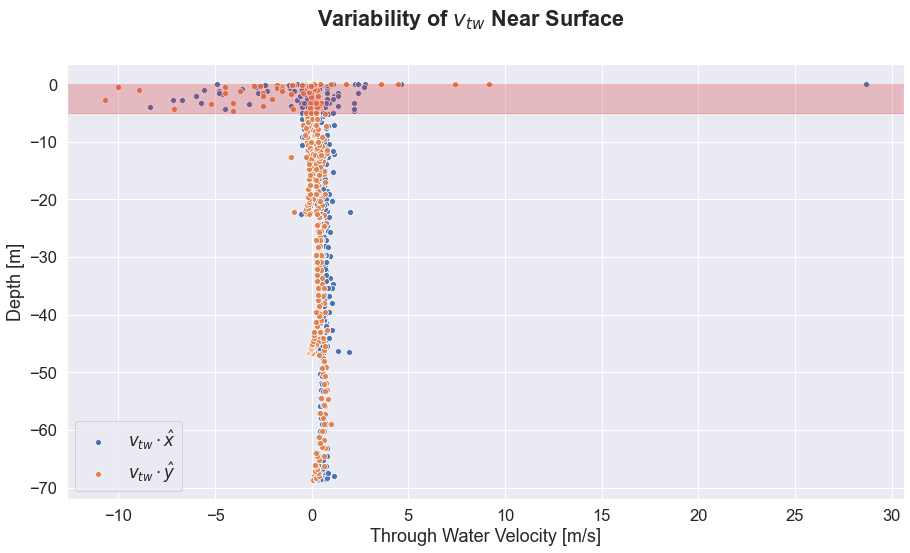

In [202]:
fig, ax = plt.subplots(figsize=(15,8))
sns.scatterplot(ts.df.rel_vel_pressure_u, -ts.df.depth, label=r'$v_{tw} \cdot \hat{x}$')
sns.scatterplot(ts.df.rel_vel_pressure_v, -ts.df.depth, label=r'$v_{tw} \cdot \hat{y}$')
# sns.scatterplot(ts.df.rel_vel_dvl_u, -ts.df.depth, label=r'$v_{tw} \cdot \hat{x}$')
# sns.scatterplot(ts.df.rel_vel_dvl_v, -ts.df.depth, label=r'$v_{tw} \cdot \hat{y}$')
plt.axhspan(0,-5, alpha=0.25, color='tab:red', label='Top 5m')
plt.xlabel("Through Water Velocity [m/s]")
plt.ylabel("Depth [m]")
plt.suptitle(r"Variability of $v_{tw}$ Near Surface ", fontweight='bold')
# plt.savefig("/Users/zduguid/Desktop/fig/variability-near-surface.png")

---
## Testing

In [ ]:
reload_modules()
import unittest

class TestOceanCurrentPropagation(unittest.TestCase):
    """Test shear-based ocean current propgation methods."""
    
    def test_bad_ocean_current_format(self):
        with self.assertRaises(ValueError):
            PathfinderUtils.OceanCurrent(0,1,None) 
            
    def test_one_observation(self):
        # set up the problem
        z = 0
        t = 0
        water_column = PathfinderUtils.WaterColumn(max_depth=20,voc_mag_filter=np.inf,voc_delta_mag_filter=np.inf)
        shear_list = [PathfinderUtils.OceanCurrent(u,v,w) for (u,v,w) in [(1,0,0),(2,0,0),(3,0,0)]]
        voc_ref = PathfinderUtils.OceanCurrent(0,0,0)
        water_column.add_shear_node(z,t,shear_list,voc_ref)
        voc0 = water_column.get_voc_at_depth(0)[0]
        voc2 = water_column.get_voc_at_depth(2)[0]
        voc4 = water_column.get_voc_at_depth(4)[0]
        voc6 = water_column.get_voc_at_depth(6)[0]
        
        # test that ShearNodes have the correct flags set
        self.assertTrue(voc0.btm_track)
        self.assertTrue(voc2.fwd_prop)
        self.assertTrue(voc4.fwd_prop)
        self.assertTrue(voc6.fwd_prop)
        
        # test that ocean current velocities are correct
        self.assertEqual(voc0.voc, PathfinderUtils.OceanCurrent( 0,0,0))
        self.assertEqual(voc2.voc, PathfinderUtils.OceanCurrent(-1,0,0))
        self.assertEqual(voc4.voc, PathfinderUtils.OceanCurrent(-2,0,0))
        self.assertEqual(voc6.voc, PathfinderUtils.OceanCurrent(-3,0,0))
        
        
    def test_forward_propagation_descending(self):
        # observation 1 
        z = 0
        t = 0
        water_column = PathfinderUtils.WaterColumn(max_depth=20,voc_mag_filter=np.inf,voc_delta_mag_filter=np.inf)
        shear_list = [PathfinderUtils.OceanCurrent(u,v,w) for (u,v,w) in [(1,0,0),(2,0,0),(3,0,0)]]
        voc_ref = PathfinderUtils.OceanCurrent(0,0,0)
        water_column.add_shear_node(z,t,shear_list,voc_ref)
        # observation 2
        z = 2
        t = 1
        shear_list = [PathfinderUtils.OceanCurrent(u,v,w) for (u,v,w) in [(0,0,0),(1,0,0)]]
        voc_ref = PathfinderUtils.OceanCurrent()
        water_column.add_shear_node(z,t,shear_list,voc_ref)
        # get shear node lists 
        voc0 = [str(sn.voc) for sn in water_column.get_voc_at_depth(0)]
        voc2 = [str(sn.voc) for sn in water_column.get_voc_at_depth(2)]
        voc4 = [str(sn.voc) for sn in water_column.get_voc_at_depth(4)]
        voc6 = [str(sn.voc) for sn in water_column.get_voc_at_depth(6)]
        # check that lengths correct 
        self.assertEqual(len(voc0), 1)
        self.assertEqual(len(voc2), 1)
        self.assertEqual(len(voc4), 2)
        self.assertEqual(len(voc6), 2)
        # check that correct velocities present 
        self.assertTrue(str(PathfinderUtils.OceanCurrent(0,0,0)) in voc0)
        self.assertTrue(str(PathfinderUtils.OceanCurrent(-1,0,0)) in voc2)
        self.assertTrue(str(PathfinderUtils.OceanCurrent(-1,0,0)) in voc4)
        self.assertTrue(str(PathfinderUtils.OceanCurrent(-2,0,0)) in voc4)
        self.assertTrue(str(PathfinderUtils.OceanCurrent(-2,0,0)) in voc6)
        self.assertTrue(str(PathfinderUtils.OceanCurrent(-3,0,0)) in voc6)
    
    def test_forward_propagation_ascending(self):
        water_column = PathfinderUtils.WaterColumn(max_depth=12,voc_mag_filter=np.inf,voc_delta_mag_filter=np.inf)
        # observation 1
        z = 8
        t = 0
        shear_list = [PathfinderUtils.OceanCurrent(u,v,w) for (u,v,w) in [(1,0,0)]]
        direction='ascending'
        voc_ref = PathfinderUtils.OceanCurrent(5,0,0)
        water_column.add_shear_node(z,t,shear_list,voc_ref,direction=direction)
        # observation 2
        z = 4
        t = 2
        shear_list = [PathfinderUtils.OceanCurrent(u,v,w) for (u,v,w) in [(-1,0,0),(0,0,0),(1,0,0)]]
        direction='ascending'
        voc_ref = PathfinderUtils.OceanCurrent()
        water_column.add_shear_node(z,t,shear_list,voc_ref,direction=voc_ref)
        # get shear node lists 
        voc4  = [str(sn.voc) for sn in water_column.get_voc_at_depth(4)]
        voc6  = [str(sn.voc) for sn in water_column.get_voc_at_depth(6)]
        voc8  = [str(sn.voc) for sn in water_column.get_voc_at_depth(8)]
        voc10 = [str(sn.voc) for sn in water_column.get_voc_at_depth(10)]
        # check that lengths correct 
        self.assertEqual(len(voc4),  1)
        self.assertEqual(len(voc6),  1)
        self.assertEqual(len(voc8),  1)
        self.assertEqual(len(voc10), 2)
        # check that correct velocities present 
        self.assertTrue(str(PathfinderUtils.OceanCurrent(5,0,0)) in voc4)
        self.assertTrue(str(PathfinderUtils.OceanCurrent(6,0,0)) in voc6)
        self.assertTrue(str(PathfinderUtils.OceanCurrent(5,0,0)) in voc8)
        self.assertTrue(str(PathfinderUtils.OceanCurrent(4,0,0)) in voc10)
        
    def test_back_propagation_descending(self):
        water_column = PathfinderUtils.WaterColumn(max_depth=14,voc_mag_filter=np.inf,voc_delta_mag_filter=np.inf)
        # observation 1
        z = 2
        t = 1
        shear_list = [PathfinderUtils.OceanCurrent(u,v,w) for (u,v,w) in [(.2,.4,-.2),(.2,.4,-.2),(.4,.8,-.4)]]
        direction='descending'
        voc_ref = PathfinderUtils.OceanCurrent()
        water_column.add_shear_node(z,t,shear_list,voc_ref,direction=direction)
        # observation 2
        z = 6
        t = 2
        shear_list = [PathfinderUtils.OceanCurrent(u,v,w) for (u,v,w) in [(.1,.2,-.1),(.2,.4,-.2)]]
        direction='descending'
        voc_ref = PathfinderUtils.OceanCurrent()
        water_column.add_shear_node(z,t,shear_list,voc_ref,direction=direction)
        # observation 3
        z = 10
        t = 3
        shear_list = [PathfinderUtils.OceanCurrent(u,v,w) for (u,v,w) in [(0,0,0)]]
        direction='descending'
        voc_ref = PathfinderUtils.OceanCurrent(0,0,0)
        water_column.add_shear_node(z,t,shear_list,voc_ref,direction=direction)
        # observation 4
        z = 8
        t = 4
        shear_list = [PathfinderUtils.OceanCurrent(u,v,w) for (u,v,w) in [(1,2,-1)]]
        direction='ascending'
        voc_ref = PathfinderUtils.OceanCurrent()
        water_column.add_shear_node(z,t,shear_list,voc_ref,direction=direction)
        # get shear node lists 
        voc2  = [str(sn.voc) for sn in water_column.get_voc_at_depth(2)]
        voc4  = [str(sn.voc) for sn in water_column.get_voc_at_depth(4)]
        voc6  = [str(sn.voc) for sn in water_column.get_voc_at_depth(6)]
        voc8  = [str(sn.voc) for sn in water_column.get_voc_at_depth(8)]
        voc10 = [str(sn.voc) for sn in water_column.get_voc_at_depth(10)]
        voc12 = [str(sn.voc) for sn in water_column.get_voc_at_depth(12)]
        # check that lengths correct 
        self.assertEqual(len(voc2),  1)
        self.assertEqual(len(voc4),  1)
        self.assertEqual(len(voc6),  1)
        self.assertEqual(len(voc8),  3)
        self.assertEqual(len(voc10), 1)
        self.assertEqual(len(voc12), 1)
        # check that correct velocities present 
        self.assertTrue(str(PathfinderUtils.OceanCurrent(0.4,0.8,-0.4)) in voc2)
        self.assertTrue(str(PathfinderUtils.OceanCurrent(0.2,0.4,-0.2)) in voc4)
        self.assertTrue(str(PathfinderUtils.OceanCurrent(0.2,0.4,-0.2)) in voc6)
        self.assertTrue(str(PathfinderUtils.OceanCurrent(0,0,0))        in voc8)
        self.assertTrue(str(PathfinderUtils.OceanCurrent(0.1,0.2,-0.1)) in voc8)
        self.assertTrue(str(PathfinderUtils.OceanCurrent(1,2,-1))       in voc8)
        self.assertTrue(str(PathfinderUtils.OceanCurrent(0,0,0))        in voc10)
        self.assertTrue(str(PathfinderUtils.OceanCurrent(0,0,0))        in voc12)
        
        
    def test_back_propagation_ascending(self):
        water_column = PathfinderUtils.WaterColumn(max_depth=14,voc_mag_filter=np.inf,voc_delta_mag_filter=np.inf)
        # observation 1
        z = 10
        t = 1
        shear_list = [PathfinderUtils.OceanCurrent(u,v,w) for (u,v,w) in [(2,0,0)]]
        direction='ascending'
        voc_ref = PathfinderUtils.OceanCurrent()
        water_column.add_shear_node(z,t,shear_list,voc_ref,direction=direction)
        # observation 2
        z = 8
        t = 2
        shear_list = [PathfinderUtils.OceanCurrent(u,v,w) for (u,v,w) in [(1,0,0)]]
        direction='ascending'
        voc_ref = PathfinderUtils.OceanCurrent()
        water_column.add_shear_node(z,t,shear_list,voc_ref,direction=direction)
        # observation 3
        z = 2
        t = 3
        shear_list = [PathfinderUtils.OceanCurrent(u,v,w) for (u,v,w) in [(-1,0,0),(0,0,0),(1,0,0)]]
        direction='ascending'
        voc_ref = PathfinderUtils.OceanCurrent(1,0,0)
        water_column.add_shear_node(z,t,shear_list,voc_ref,direction=direction)
        # get shear node lists 
        voc2  = [str(sn.voc) for sn in water_column.get_voc_at_depth(2)]
        voc4  = [str(sn.voc) for sn in water_column.get_voc_at_depth(4)]
        voc6  = [str(sn.voc) for sn in water_column.get_voc_at_depth(6)]
        voc8  = [str(sn.voc) for sn in water_column.get_voc_at_depth(8)]
        voc10 = [str(sn.voc) for sn in water_column.get_voc_at_depth(10)]
        voc12 = [str(sn.voc) for sn in water_column.get_voc_at_depth(12)]
        # check that lengths correct 
        self.assertEqual(len(voc2),  1)
        self.assertEqual(len(voc4),  1)
        self.assertEqual(len(voc6),  1)
        self.assertEqual(len(voc8),  1)
        self.assertEqual(len(voc10), 1)
        self.assertEqual(len(voc12), 1)
        # check that correct velocities present 
        self.assertTrue(str(PathfinderUtils.OceanCurrent(1, 0,0)) in voc2)
        self.assertTrue(str(PathfinderUtils.OceanCurrent(2, 0,0)) in voc4)
        self.assertTrue(str(PathfinderUtils.OceanCurrent(1, 0,0)) in voc6)
        self.assertTrue(str(PathfinderUtils.OceanCurrent(0, 0,0)) in voc8)
        self.assertTrue(str(PathfinderUtils.OceanCurrent(-1,0,0)) in voc10)
        self.assertTrue(str(PathfinderUtils.OceanCurrent(-3,0,0)) in voc12)
    
    def test_bin_filter(self):
        water_column = PathfinderUtils.WaterColumn(max_depth=14,start_filter=2,voc_mag_filter=np.inf,voc_delta_mag_filter=np.inf)
        # observation 1
        z = 0
        t = 1
        shear_list = [PathfinderUtils.OceanCurrent(u,v,w) for (u,v,w) in [(1,0,0),(2,0,0),(3,0,0),(4,0,0)]]
        direction='descending'
        voc_ref = PathfinderUtils.OceanCurrent(0,0,0)
        water_column.add_shear_node(z,t,shear_list,voc_ref,direction=direction)
        # get shear node lists 
        voc0  = [str(sn.voc) for sn in water_column.get_voc_at_depth(0)]
        voc2  = [str(sn.voc) for sn in water_column.get_voc_at_depth(2)]
        voc4  = [str(sn.voc) for sn in water_column.get_voc_at_depth(4)]
        voc6  = [str(sn.voc) for sn in water_column.get_voc_at_depth(6)]
        voc8  = [str(sn.voc) for sn in water_column.get_voc_at_depth(8)]
        # check that lengths correct 
        self.assertEqual(len(voc0),  1)
        self.assertEqual(len(voc2),  0)
        self.assertEqual(len(voc4),  0)
        self.assertEqual(len(voc6),  1)
        self.assertEqual(len(voc8),  1)
        # check that correct velocities present 
        self.assertTrue(str(PathfinderUtils.OceanCurrent(0, 0,0)) in voc0)
        self.assertTrue(str(PathfinderUtils.OceanCurrent(-3,0,0)) in voc6)
        self.assertTrue(str(PathfinderUtils.OceanCurrent(-4,0,0)) in voc8)


if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored','-v'], exit=False)

In [ ]:
#######################################################
# MODE 4: Ascending Back Propagation ##################
#######################################################
reload_modules()
water_column = PathfinderUtils.WaterColumn(max_depth=14)

# observation 1
z = 10
t = 1
shear_list = [PathfinderUtils.OceanCurrent(u,v,w) for (u,v,w) in [(2,0,0)]]
direction='ascending'
voc_ref = PathfinderUtils.OceanCurrent()
water_column.add_shear_node(z,t,shear_list,voc_ref,direction=direction)

# observation 2
z = 8
t = 2
shear_list = [PathfinderUtils.OceanCurrent(u,v,w) for (u,v,w) in [(1,0,0)]]
direction='ascending'
voc_ref = PathfinderUtils.OceanCurrent()
water_column.add_shear_node(z,t,shear_list,voc_ref,direction=direction)

# observation 3
z = 2
t = 3
shear_list = [PathfinderUtils.OceanCurrent(u,v,w) for (u,v,w) in [(-1,0,0),(0,0,0),(1,0,0)]]
direction='ascending'
voc_ref = PathfinderUtils.OceanCurrent(1,0,0)
water_column.add_shear_node(z,t,shear_list,voc_ref,direction=direction)

print(water_column)

In [ ]:
#######################################################
# MODE 3: Descending Back Propagation #################
#######################################################
reload_modules()
water_column = PathfinderUtils.WaterColumn(max_depth=14)

# observation 1
z = 2
t = 1
shear_list = [PathfinderUtils.OceanCurrent(u,v,w) for (u,v,w) in [(.2,.4,-.2),(.2,.4,-.2),(.4,.8,-.4)]]
direction='descending'
voc_ref = PathfinderUtils.OceanCurrent()
water_column.add_shear_node(z,t,shear_list,voc_ref,direction=direction)

# observation 2
z = 6
t = 2
shear_list = [PathfinderUtils.OceanCurrent(u,v,w) for (u,v,w) in [(.1,.2,-.1),(.2,.4,-.2)]]
direction='descending'
voc_ref = PathfinderUtils.OceanCurrent()
water_column.add_shear_node(z,t,shear_list,voc_ref,direction=direction)

# observation 3
z = 10
t = 3
shear_list = [PathfinderUtils.OceanCurrent(u,v,w) for (u,v,w) in [(0,0,0)]]
direction='descending'
voc_ref = PathfinderUtils.OceanCurrent(0,0,0)
water_column.add_shear_node(z,t,shear_list,voc_ref,direction=direction)

# observation 4
z = 8
t = 4
shear_list = [PathfinderUtils.OceanCurrent(u,v,w) for (u,v,w) in [(1,2,-1)]]
direction='ascending'
voc_ref = PathfinderUtils.OceanCurrent()
water_column.add_shear_node(z,t,shear_list,voc_ref,direction=direction)

print(water_column)

In [ ]:
#######################################################
# MODE 2: Ascending Forward Propagation ###############
#######################################################
reload_modules()
water_column = PathfinderUtils.WaterColumn(max_depth=12)

# observation 1
z = 8
t = 0
shear_list = [PathfinderUtils.OceanCurrent(u,v,w) for (u,v,w) in [(1,0,0)]]
direction='ascending'
voc_ref = PathfinderUtils.OceanCurrent(5,0,0)
water_column.add_shear_node(z,t,shear_list,voc_ref,direction=direction)

# observation 2
z = 4
t = 2
shear_list = [PathfinderUtils.OceanCurrent(u,v,w) for (u,v,w) in [(-1,0,0),(0,0,0),(1,0,0)]]
direction='ascending'
voc_ref = PathfinderUtils.OceanCurrent()
water_column.add_shear_node(z,t,shear_list,voc_ref,direction=voc_ref)

print(water_column)

In [ ]:
#######################################################
# MODE 1: Descending Forward Propagation ##############
#######################################################
reload_modules()
water_column = PathfinderUtils.WaterColumn(max_depth=10)

# observation 1
z = 0
t = 0
shear_list = [PathfinderUtils.OceanCurrent(u,v,w) for (u,v,w) in [(1,0,0),(2,0,0),(3,0,0)]]
voc_ref = PathfinderUtils.OceanCurrent(0,0,0)
water_column.add_shear_node(z,t,shear_list,voc_ref)

# observation 2
z = 2
t = 1
shear_list = [PathfinderUtils.OceanCurrent(u,v,w) for (u,v,w) in [(0,0,0),(1,0,0)]]
voc_ref = PathfinderUtils.OceanCurrent()
water_column.add_shear_node(z,t,shear_list,voc_ref)

print(water_column)